# What is the use of Spatial Transformer Networks?

Spatial Transformer Networks (STNs) provide a mechanism for the network to learn spatial transformations of the input data. This allows the model to focus on relevant features even when objects in the image are rotated, scaled, or shifted. In essence, STNs make the overall system more spatially invariant and robust to variations in the input.

# Torchvision Transformers vs Spatial Transfromer Networks?

The key difference is that torchvision transforms (e.g., rotate, scale, shift) are static, pre-defined data augmentation operations applied outside the network, while Spatial Transformer Networks (STNs) are learnable, differentiable modules embedded inside the network.

Torchvision Transforms:
  - Applied to the input data before training or inference.
  - They are non-adaptive; the transformation parameters are fixed or randomly sampled, not learned from the data.
  - Primarily used to icnrease dataset diversity via augmentation.

Spatial Transformer Networks:
  - Integrated directly into the network architecture.
  - They learn the best transformation (e.g., affine, cropping) to make the features more robust during training.
  - The parameters for these transformations are optimized via backpropagation based on the model's overall objective.

So, while both approaches aim to introduce invariance (e.g., to rotation, scale or translation), STNs adapt their transformations during training, making the model inherently more robust, whereas torchvision transforms simply augment the data before it is seen by the model.

# Dwe use STN in validation and testing as well?

STNs are part of the network's architecture, so they are used during both training and evaluation (validaiton/testing). Unlike data augmentations that might be turned off during testing, the learned spatial transformer is applied to every input once the model is deployed, ensuring the spatial adjustments are consistenly maintained.

In [1]:
# License: BSD
# Author: Ghassen Hamrouni

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

# Loading the data

In [2]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
  datasets.MNIST(root='data', train=True, download=True,
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307,), (0.3081,))
                 ])),
  batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
  datasets.MNIST(root='data', train=False, 
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307,), (0.3081,))
                 ])),
  batch_size=64, shuffle=True, num_workers=4)

# Depicting spatial transformer networks

In [3]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

    # Spatial transformer localization-network
    self.localization = nn.Sequential(
      nn.Conv2d(1, 8, kernel_size=7), # It learns filters that capture patterns relevant 
                                      # for estiamting the transformation.
      nn.MaxPool2d(2, stride=2),      # Reduces the dimensionality of the feature maps 
                                      # and provides translation invariance, 
                                      # which helps summarize features over local regions.
      nn.ReLU(True),                  # Applies non-linearity, allowing the network
                                      # to model more complex functions
                                      # that are necessary to predict the affine
                                      # transformation parameters.
      nn.Conv2d(8, 10, kernel_size=5),
      nn.MaxPool2d(2, stride=2),
      nn.ReLU(True)
    )

    # Regressor for the 3 * 2 affine matrix
    self.fc_loc = nn.Sequential(
      nn.Linear(10 * 3 * 3, 32),
      nn.ReLU(True),
      nn.Linear(32, 3 * 2)
    )

    # Initialize the weights/bias with identity transformation
    self.fc_loc[2].weight.data.zero_()
    self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

  # Spatial transformer network forward function
  # x.size() = torch.Size([N, 1, 28, 28])
  def stn(self, x: torch.Tensor):
    xs: torch.Tensor = self.localization(x)
    xs = xs.view(-1, 10 * 3 * 3) # flatten the output of the localization network [N, 90]
    theta: torch.Tensor = self.fc_loc(xs) # [N, 6]
    theta = theta.view(-1, 2, 3) # [N, 2, 3]

    grid = F.affine_grid(theta, x.size()) # creates a grid of coordinates
                                          # that maps out the output image pixels
                                          # to the corresponding input image pixels
                                          # using the predicted affine transformatin matrix (theta).
                                          # Essentially, it tells the network 
                                          # where to look in the input image
                                          # for each output pixel.
                                          # [N, 28, 28, 2]
                                          # the last dimension (2) holds the (x, y) coordiantes for each pixel

    x = F.grid_sample(x, grid) # to sample the input image and produce a transformed
                               # output image. It performs interpolation
                               # over the input pixels based on the computed coordinates,
                               # effectively applying the affien transformation to the image.
                               # Interpolation is a method for estimating unknown values from
                               # know discrete samples.
                               # [N, 1, 28, 28]

    return x

  # x.size() = torch.Size([N, 1, 28, 28])
  def forward(self, x: torch.Tensor):
    # transform the input
    x = self.stn(x)                                             # [N, 1, 28, 28]

    # Perform the usual forward pass
    x = F.relu(F.max_pool2d(self.conv1(x), 2))                  # [N, 1, 28, 28] ->
                                                                # 28 + 0 - 4 - 1 / 1 + 1 = 24 ->
                                                                # [N, 10, 24, 24] ->
                                                                # 24 + 0 - 1 - 1 / 2 + 1 = 12 ->
                                                                # [N, 10, 12, 12]
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # [N, 10, 12, 12] ->
                                                                # 12 + 0 - 4 - 1 / 1 + 1 = 8 ->
                                                                # [N, 20, 8, 8] ->
                                                                # 8 + 0 - 1 - 1 / 2 + 1 = 4 ->
                                                                # [N, 20, 4, 4]
    x = x.view(-1, 320)                                         # [N, 320]
    x = F.relu(self.fc1(x))                                     # [N, 320] -> [N, 50]
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)                                             # [N, 50] -> [N, 10]
    return F.log_softmax(x, dim=1)


model = Net().to(device)

# Training the model

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 500 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#

def test():
  with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)

      # sum up batch loss
      test_loss += F.nll_loss(output, target, size_average=False).item()
      # get the index of the max log-probability
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))

# Visualizing the STN results

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5082: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5015: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.447967
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.990083


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2740, Accuracy: 9219/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.542094
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.334033

Test set: Average loss: 0.1359, Accuracy: 9601/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.297810
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.399326

Test set: Average loss: 0.7158, Accuracy: 7780/10000 (78%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.258561
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.345797

Test set: Average loss: 0.0787, Accuracy: 9757/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.126840
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.297407

Test set: Average loss: 0.0750, Accuracy: 9770/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.243881
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.111597

Test set: Average loss: 1.0759, Accuracy: 7165/10000 (72%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.809698
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.058752

Test set: Average loss: 0.0849, Accuracy: 9758/10000 (98%)

Tra

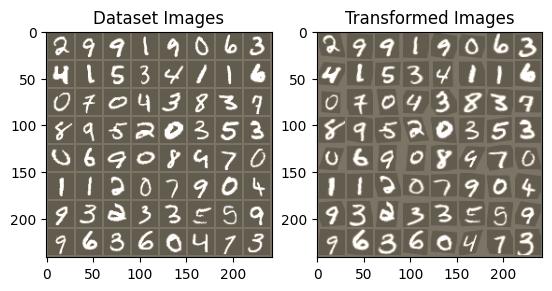

In [5]:
def convert_image_np(inp: torch.Tensor):
  """Convert a Tensor to numpy image."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean # unnormalize
  inp = np.clip(inp, 0, 1)
  return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.

def visualize_stn():
  with torch.no_grad():
    # Get a batch of training data
    data = next(iter(test_loader))[0].to(device)

    input_tensor = data.cpu()
    # we are going ot use the model stn output to convert_image_np
    # which use .numpy()
    # operations like .numpy() only work on CPU tensors.
    transformed_input_tensor = model.stn(data).cpu()

    in_grid = convert_image_np(
      torchvision.utils.make_grid(input_tensor))

    out_grid = convert_image_np(
      torchvision.utils.make_grid(transformed_input_tensor))

    # Plot the results side-by-side
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset Images')

    axarr[1].imshow(out_grid)
    axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
  train(epoch)
  test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()